In [1]:
from architecture import pipe
from PIL import Image
from dataloader import testing_dataset
from util import util
from torch.utils.data import DataLoader
import torch
from torch.nn import BCELoss

D:\ml\mtest\learn_env\lib\site-packages\diffusers\utils\outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
D:\ml\mtest\learn_env\lib\site-packages\diffusers\utils\outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
D:\ml\mtest\learn_env\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [2]:
state = torch.load('./saves/exp_5/model_epoch_3.pth')

In [3]:
pipe.model.load_state_dict(state['model_state_dict'])
pipe.model = pipe.model.eval()

In [4]:
dataset = DataLoader(testing_dataset, shuffle=True)

In [46]:
sample = next(iter(dataset))

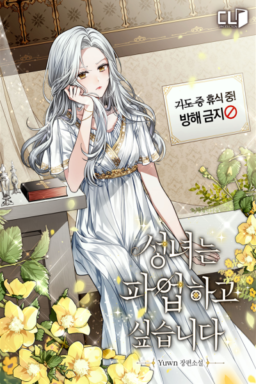

In [47]:
util.to_pil(sample[0][0])

In [48]:
print(sample[1])
util.to_classes(sample[1])

tensor([[0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0')


(['romance', 'fantasy', 'comedy'], [1.0, 1.0, 1.0])

In [49]:
res = pipe.pipe(sample[0])
res

tensor([[0.6660, 0.4822, 0.5366, 0.3000, 0.6392, 0.6157, 0.4219, 0.2729, 0.4260,
         0.4504, 0.3743, 0.6450, 0.2795, 0.5264, 0.4390, 0.3325, 0.4285, 0.4995,
         0.5000, 0.4507, 0.4001, 0.2542, 0.5356, 0.4646, 0.3040, 0.4556]],
       device='cuda:0', dtype=torch.float16, grad_fn=<SigmoidBackward0>)

In [52]:
util.pick_top(res[0], 6, prettify=True)

(['action', 'martial arts', 'drama', 'ecchi', 'adventure', 'slice of life'],
 [0.666015625,
  0.64501953125,
  0.63916015625,
  0.61572265625,
  0.53662109375,
  0.53564453125])

In [45]:
util.calculate_precession(res, sample[1], cutoff=.65)

tensor([-0.2500])